# Do Timestamps Match up?

Timestamp Test comparing monocular ximea camera captured using Ximea Plugin for Pupil Capture with Intel Realsesense camera recorded in parallel

In [4]:
import imp
import run_analysis as ana
from ximea import xiapi
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import ximea_cam_aquire_save as xim

from time import sleep, time
import pupil_cam_aquire_save as pup
import zmq_socket as zmqs
#import pupil_src.shared_modules.file_methods as pupfm
import threading

## Paths for Timestamps Files

In [5]:
date = '2020_02_09'
rnumber = '000'
subject_name = 'TEST_SUBJECT'
task_name = 'TEST_TASK'

realsense_path = f'/home/vasha/recordings/{date}/{rnumber}'
rs_timestamp_path = os.path.join(realsense_path,'world_timestamps.npy')
rs_movie_path = os.path.join(realsense_path,'world.mp4')

ximea_path = f'/home/vasha/ximea_recordings/{subject_name}/{task_name}'
xim_timestamp_path = os.path.join(ximea_path,'timestamps_ximea.tsv')
xim_timestamp_sync_path = os.path.join(ximea_path,'timestamp_camsync_ximea.tsv')
xim_movie_path = os.path.join(ximea_path,'ximea')


## Frame Skips

xim missed frames total: 1.0 / 788 = 0.13%


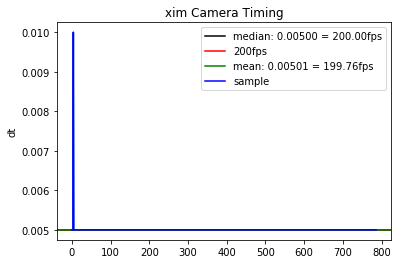

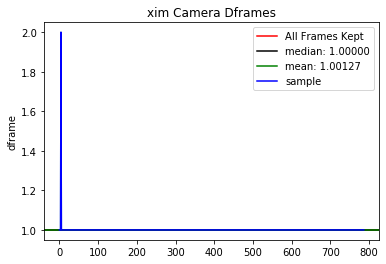

In [7]:
ana.count_missed_frames(xim_timestamp_path, 'xim')
ana.plot_camera_timing(xim_timestamp_path, './test_timestamps/timestamps_plot_xim.png', 'xim')
ana.plot_camera_dframe(xim_timestamp_path, './test_timestamps/timestamps_plot_xim.png', 'xim')

## Convert to unified wall clock time

In [47]:
imp.reload(ana)
ximea_timestamps_table = ana.convert_ximea_time_to_unix_time(xim_timestamp_path, xim_timestamp_sync_path)
ximea_timestamps = ximea_timestamps_table[:,3]
ximea_timestamp_converted_path = os.path.join(analysis_folder,'timestamps_converted.tsv')

#np.savetxt(od_ximea_timestamp_converted_path, od_ximea_timestamps, fmt='%10.5f', delimiter='\t')
np.savetxt(ximea_timestamp_converted_path, ximea_timestamps_table, fmt='%10.5f', delimiter='\t')

Time Elapsed: 3.9358242244999815 seconds
Time Drift pre to post: 0.0007650075000356082 seconds
397.94609796550003


## Compare Timestamp Ranges

### Ximea Movie

In [58]:
print(f'{len(ximea_timestamps)} Ximea Timestamps: {ximea_timestamps[0]} : {ximea_timestamps[-1]}')

788 Ximea Timestamps: 397.94609796550003 : 401.8858879655


### Realsense Movie

In [70]:
rs_timestamps = np.load(rs_timestamp_path)
rs_interp_timestamps = np.linspace(rs_timestamps[0], rs_timestamps[-1], round(len(rs_timestamps)*(200./30)))
print(f'{len(rs_timestamps)} Realsense Timestamps: {rs_timestamps[0]} : {rs_timestamps[-1]}')
print(f'{len(rs_interp_timestamps)} Realsense 200Hz Interpolated Timestamps: {rs_interp_timestamps[0]} : {rs_interp_timestamps[-1]}')

118 Realsense Timestamps: 397.991266784 : 401.862140643
787 Realsense 200Hz Interpolated Timestamps: 397.991266784 : 401.862140643


### Pupil Cams

In [81]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy'))
gaze_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'gaze_timestamps.npy'))
pupil_0_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'eye0_timestamps.npy'))
pupil_1_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'eye1_timestamps.npy'))
print(f'{len(gaze_ts)} Gaze Timestamps: {gaze_ts[0]} : {gaze_ts[-1]}')
print(f'{len(pupil_ts)} Pupil Timestamps: {pupil_ts[0]} : {pupil_ts[-1]}')
print(f'{len(pupil_0_ts)} Pupil 1 Timestamps: {pupil_0_ts[0]} : {pupil_0_ts[-1]}')
print(f'{len(pupil_1_ts)} Pupil 2 Timestamps: {pupil_1_ts[0]} : {pupil_1_ts[-1]}')

32463 Gaze Timestamps: 1574736104.390689 : 1574736185.777338
32463 Pupil Timestamps: 1574736104.390689 : 1574736185.777338
16243 Pupil 1 Timestamps: 1574736104.4107149 : 1574736185.797364
16221 Pupil 2 Timestamps: 1574736104.4078338 : 1574736185.7930112


This is strange... Pupil Player combines the pupil cameras and realsense cameras seamlessly in pupil player - yet their timestamps as shown here are totally different.

### Plot

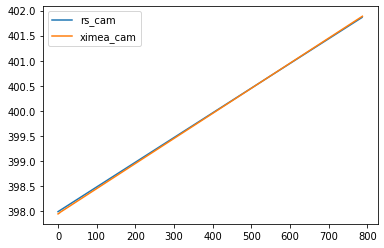

In [82]:
plt.plot(rs_interp_timestamps, label='rs_cam')
plt.plot(ximea_timestamps, label='ximea_cam')
plt.legend()

Ximea and Realsense timestamps look pretty similar. Let's see if the frames line up.

## Compare Frames 
Compare the ximea and realsense frames 

In [118]:
print(ximea_timestamps[0], ximea_timestamps[-1])
print(rs_timestamps[0], rs_timestamps[-1])

397.94609796550003 401.8858879655
397.991266784 401.862140643


In [140]:
timestamp = 399.05
xi_fnum = ana.ximea_timestamp_to_framenum(ximea_timestamp_converted_path, timestamp)[0]
rs_fnum = ana.pupil_timestamp_to_framenum(rs_timestamp_path, timestamp)[0]
print(xi_fnum, rs_fnum)

220 33


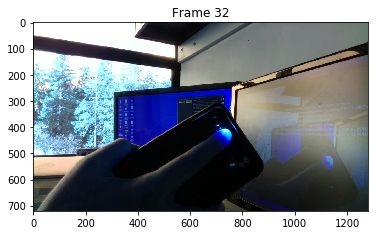

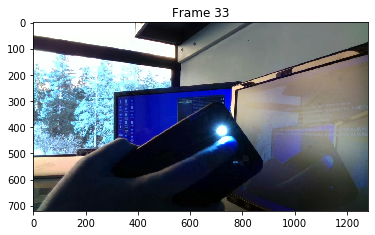

Text(0.5, 1.0, 'Frame 34')

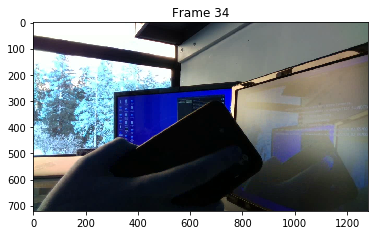

In [141]:
rs_frame = ana.pupil_get_frame(rs_movie_path, rs_fnum-1)
plt.imshow(rs_frame)
plt.title(f'Frame {rs_fnum-1}')
plt.show()

rs_frame = ana.pupil_get_frame(rs_movie_path, rs_fnum)
plt.imshow(rs_frame)
plt.title(f'Frame {rs_fnum}')
plt.show()

rs_frame = ana.pupil_get_frame(rs_movie_path, rs_fnum+1)
plt.imshow(rs_frame)
plt.title(f'Frame {rs_fnum+1}')

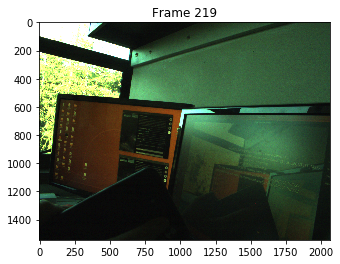

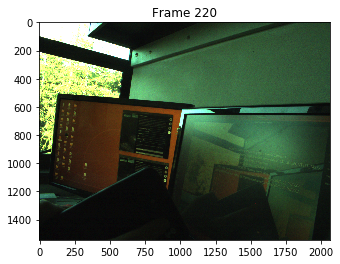

Text(0.5, 1.0, 'Frame 221')

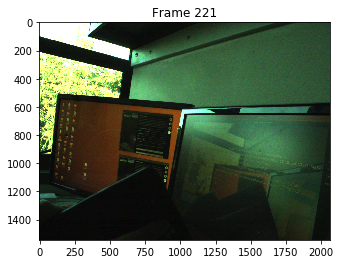

In [142]:
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(xi_fnum-1, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {xi_fnum-1}')
plt.show()

xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(xi_fnum, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {xi_fnum}')
plt.show()

xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(xi_fnum+1, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {xi_fnum+1}')

In [31]:
os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy')

'/home/vasha/Desktop/backpack_computer_aquisition/test_timestamps/pupil/000/pupil_timestamps.npy'

In [28]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy'))
pupil_ts_eye_a = pupil_ts[::2]
pupil_ts_eye_b = pupil_ts[1::2]

In [29]:
pupil_ts_eye_a

array([1.57473610e+09, 1.57473610e+09, 1.57473610e+09, ...,
       1.57473619e+09, 1.57473619e+09, 1.57473619e+09])

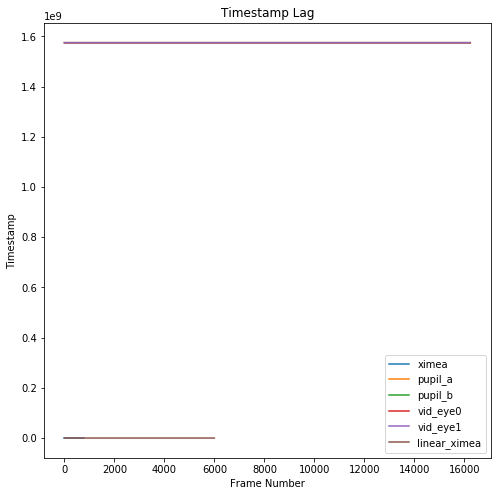

In [10]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy'))
pupil_ts_eye_a = pupil_ts[::2]
pupil_ts_eye_b = pupil_ts[1::2]
#pupil_ts_gaze = np.load(os.path.join(pupil_save_dir_name, rnumber, 'gaze_timestamps.npy'))
pupil_ts_eye0 = np.load(os.path.join(pupil_save_dir_name, rnumber, 'eye0_timestamps.npy'))
pupil_ts_eye1 = np.load(os.path.join(pupil_save_dir_name, rnumber, 'eye1_timestamps.npy'))
pupil_annotations = np.load(os.path.join(pupil_save_dir_name, rnumber, 'annotation_timestamps.npy'))

#ximea timestamps
with open(ximea_timestamp_converted_path, 'r') as f:
    timestamps_ximea = list(zip(line.strip().split('\t') for line in f))
    timestamps_ximea = np.squeeze(np.array(timestamps_ximea[1:]).astype('float'))
    timestamps_ximea = timestamps_ximea[:,-1]

linear_ximea = np.arange(0,collection_mins*200*60*0.005, 0.005)+timestamps_ximea[0]
linear_pupil = np.arange(0, collection_mins*200*60*0.005, 0.005)+pupil_ts[0]

plt.figure(figsize=(8,8))
plt.plot(timestamps_ximea, label='ximea')
plt.plot(pupil_ts_eye_a, label='pupil_a')
plt.plot(pupil_ts_eye_b, label='pupil_b')
#plt.plot(pupil_ts_gaze, label='gaze')
plt.plot(pupil_ts_eye0, label='vid_eye0')
plt.plot(pupil_ts_eye1, label='vid_eye1')
plt.plot(linear_ximea, label='linear_ximea')
#plt.plot(linear_pupil, label='linear_pupil')
plt.legend()
plt.xlabel('Frame Number')
plt.ylabel('Timestamp')
plt.title('Timestamp Lag')
plt.legend()

In [11]:
pupil_ts_eye_a[0],pupil_ts_eye_a[1]

(1574736104.390689, 1574736104.395696)

In [25]:
timestamps_ximea[0],timestamps_ximea[1], 

(1574742196.359, 1574742196.364)

In [17]:
linear_pupil[0] - pupil_ts_eye_a[0]

0.0

In [20]:
linear_pupil[5970] - pupil_ts_eye_a[5970]

-0.15585708618164062

In [23]:
linear_pupil[400] - pupil_ts_eye_a[400]

-0.002727031707763672

In [25]:
linear_pupil[5970] - pupil_ts_eye_a[5970]

-0.15585708618164062

In [26]:
print(len(linear_ximea))
print(len(pupil_ts_eye_a))


6000
5971


In [27]:
print(len(timestamps_ximea), len(linear_ximea))

5959 6000


In [28]:
timestamps_ximea[0] - linear_ximea[0]

0.0

In [29]:
timestamps_ximea[100] - linear_ximea[100]

0.044970035552978516

In [30]:
timestamps_ximea[1000] - linear_ximea[1000]

0.5659699440002441

In [26]:
timestamps_ximea[23828] - linear_ximea[23828]

2.6085100173950195

In [29]:
len(ximea_ts)

NameError: name 'ximea_ts' is not defined

In [30]:
pupil_ts[0]

1574301576.4886224

In [11]:
pupil_ts[1]

1574301576.4910474

In [12]:
pupil_ts[2]

1574301576.4936295

In [13]:
pupil_ts[3]

1574301576.4960544

In [33]:
timestamps_ximea[0] - pupil_ts_eye0[0]

2.596371650695801

In [34]:
timestamps_ximea[47500] - pupil_ts_eye0[47500]

24.291245698928833

In [32]:
timestamps_ximea[47500] - pupil_ts_eye0[47500]

24.291245698928833

In [ ]:
timestamps_ximea[0]

In [ ]:
timestamps_ximea[1]

In [ ]:
timestamps_ximea[2]

In [ ]:
print(pupil_ts_eye0[0])
print(pupil_ts_eye1[0])


In [ ]:
pupil_ts_eye0[1]

In [ ]:
pupil_ts_eye0[2]

In [ ]:
timestamps_ximea

In [ ]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy'))
pupil_ts_file_eye0 = os.path.join(pupil_save_dir_name, rnumber, 'eye0_timestamps.npy')
pupil_ts_file_eye1 = os.path.join(pupil_save_dir_name, rnumber, 'eye1_timestamps.npy')


    
#pupil timestamps
ts_pupil = np.load(pupil_ts)
timestamps_pupil_eye0 = np.load(pupil_ts_file_eye0)
timestamps_pupil_eye1 = np.load(pupil_ts_file_eye1)


plt.plot(ts_pupil,label='pupil')
plt.plot(timestamps_pupil_eye1,label='pupil_eye1')
plt.plot(timestamps_pupil_eye0,label='pupil_eye0')
plt.plot(timestamps_ximea,label='ximea')


In [13]:
ximea_timestamp_converted_path

'./test_timestamps/analysis/timestamps_converted.tsv'

## Find Image of Two Ximea Cameras near Turn-off Point

In [12]:
imp.reload(ana)
target_framenum = 1000
target_timestamp = ana.ximea_framenum_to_timestamp(ximea_timestamp_converted_path, target_framenum)

frame, ts = ana.ximea_timestamp_to_framenum(ximea_timestamp_converted_path, target_timestamp)

ts_pre = ana.ximea_framenum_to_timestamp(ximea_timestamp_converted_path, frame-1) #reverse
ts_post = ana.ximea_framenum_to_timestamp(ximea_timestamp_converted_path, frame+1) #reverse


TypeError: only size-1 arrays can be converted to Python scalars

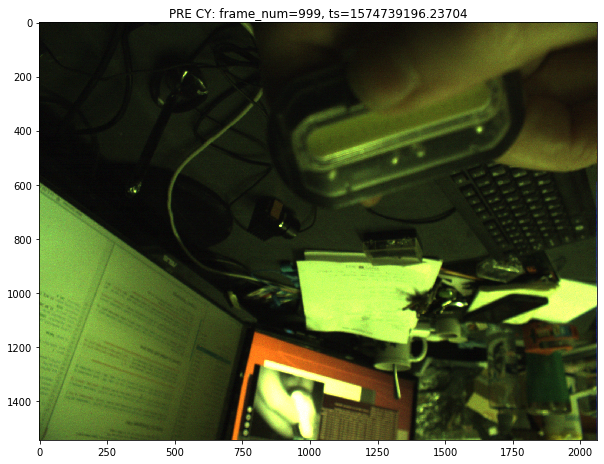

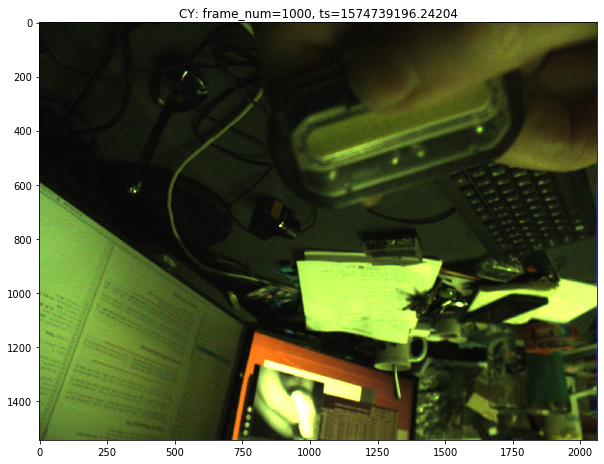

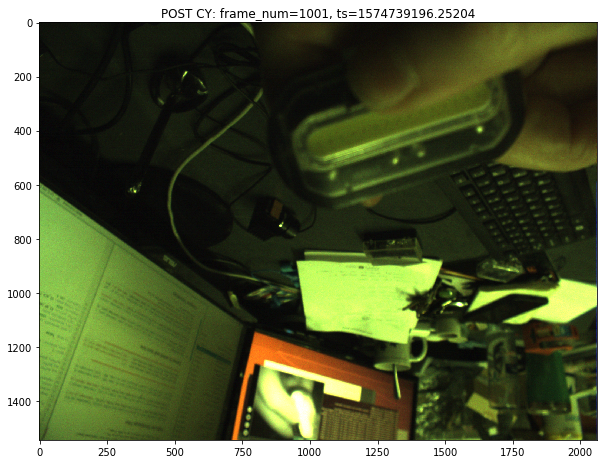

In [33]:
#img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy_pre = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[0])
img_cy_post = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[0])

#plt.imshow(img_od)
#plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
#plt.show()
plt.figure(figsize=(10,13))
plt.imshow(img_cy_pre)
plt.title(f'PRE CY: frame_num={frame_cy-1}, ts={ts_cy_pre}')
plt.show()

plt.figure(figsize=(10,13))
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

plt.figure(figsize=(10,13))
plt.imshow(img_cy_post)
plt.title(f'POST CY: frame_num={frame_cy+1}, ts={ts_cy_post}')
plt.show()

## Turn On - OD

In [34]:
# imp.reload(ana)
# img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
# plt.show()

# img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
# plt.show()

# img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
# plt.show()

## Turn On - OS

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Find Image of Two Ximea Cameras near Turn-off Point

In [ ]:
imp.reload(ana)
target_timestamp = 5837.48

frame_od, ts_od = ana.ximea_timestamp_to_framenum(od_timestamp_path, target_timestamp)
frame_cy, ts_cy = ana.ximea_timestamp_to_framenum(cy_timestamp_path, target_timestamp)
#ts_cy = ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy) #reverse

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])

In [ ]:
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
plt.show()
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

## Turn Off - OD

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
plt.show()

## Turn Off - CY

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Turn Off - Pupil Labs Eye 1

Timestamps are syncing up - this seems a bit unexpected. Checking manually it looks like the only happens some of the time. I wonder if it may have something to do with the bandwidth being limited.  

In [35]:
imp.reload(ana)

pupil_ts_file = os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy')
#ana.pupil_framenum_to_timestamp(pupil_file, 120)
pupil_fnum, pupil_timestamp = ana.pupil_timestamp_to_framenum(pupil_ts_file, target_timestamp)
print(f'Target: {target_timestamp}')
print(f'Actual: {pupil_timestamp}')
print(f'Frame: {pupil_fnum}')

Target: 1574739196.24204
Actual: 1574739196.241019
Frame: 1751


In [36]:
pupil_vid_file = os.path.join(pupil_save_dir_name, pupil_num, 'eye0.mp4')

frame_pup_pre = ana.pupil_get_frame(pupil_vid_file, pupil_fnum-1)
ts_pup_pre = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum-1)

frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum)
ts_pup = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum)

frame_pup_post = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+1)
ts_pup_post = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum+1)

frame_pup_post2 = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+2)
ts_pup_post2 = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum+2)


Target Time: 1574739196.24204


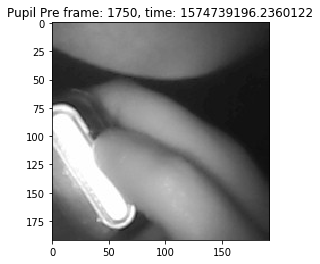

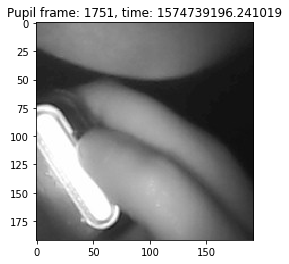

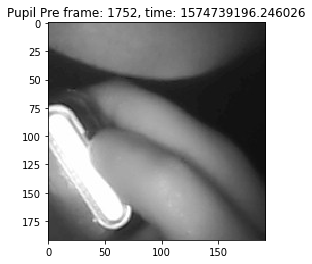

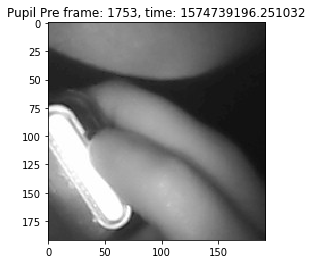

In [37]:
print(f'Target Time: {target_timestamp}')

plt.imshow(frame_pup_pre)
plt.title(f'Pupil Pre frame: {pupil_fnum-1}, time: {ts_pup_pre}')
plt.show()

plt.imshow(frame_pup)
plt.title(f'Pupil frame: {pupil_fnum}, time: {ts_pup}')
plt.show()

plt.imshow(frame_pup_post)
plt.title(f'Pupil Pre frame: {pupil_fnum+1}, time: {ts_pup_post}')
plt.show()

plt.imshow(frame_pup_post2)
plt.title(f'Pupil Pre frame: {pupil_fnum+2}, time: {ts_pup_post2}')
plt.show()

In [ ]:
n=1000 #5 seconds

xim_frame_means = []
for i in range(0,n):
    frame_xim = ana.ximea_get_frame(pupil_fnum+i, save_batchsize, 'cy', ximea_save_folder_list[0])
    xim_frame_means.append(np.mean(frame_xim))
    
pup_frame_means = ana.pupl_get_framemeans(pupil_vid_file, pupil_fnum, n)


In [ ]:
pn = pup_frame_means - np.min(pup_frame_means)
pn = pn/np.max(pn)
xn = xim_frame_means - np.min(xim_frame_means)
xn = xn/np.max(xn)
plt.plot(pn,label='pupil')
plt.plot(xn,label='ximea')
plt.legend()

In [ ]:
n=500
frame_means = np.zeros(n)
for i in range(0,n,5):
    frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+i)
    frame_means[i] = np.mean(frame_pup)
plt.plot(frame_means)

In [ ]:
for i in range(20):
    frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+i)
    plt.imshow(frame_pup)
    plt.show()

In [ ]:
ts = np.load(od_pupil_timestamp_path)

In [ ]:
ts.shape

In [ ]:
ts[:10]